In [340]:
# %%writefile model/disease_detection.py
import torch
from torchvision import transforms

import numpy as np
from PIL import Image
from pathlib import Path

from model.model_builder import resnet18_model

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import asyncio

class AI_model:
    def __init__(self, path_to_model: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.model, info_data = resnet18_model(pretrain_model_path= path_to_model)
        self.class_names = info_data['class_names']

        self.img_transform_for_predict = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor(),
            transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
        ])

        self.img_transform_for_result = transforms.Compose([
            transforms.Resize(size= 224),
            transforms.ToTensor(),
        ])
        
        target_layers = [self.model.layer4[-1]]
        # self.cam = GradCAM(model=self.model, target_layers=target_layers)
        self.cam = ScoreCAM(model=self.model, target_layers=target_layers)
        # self.cam = HiResCAM(model=self.model, target_layers=target_layers)
        # self.cam = GradCAMPlusPlus(model=self.model, target_layers=target_layers)
        # self.cam = AblationCAM(model=self.model, target_layers=target_layers)
        
    async def predict(self, img: Image):   
        img_tensor = self.img_transform_for_predict(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        # rgb_img = img_tensor.permute(1, 2, 0).numpy()
        
        
        
        self.model.eval()
        with torch.inference_mode():
            
            
            predict = self.model(img_tensor_in_batch)
            soft_max_persent = torch.softmax(predict, dim= 1)
            predicted_class = self.class_names[torch.argmax(predict, dim= 1)]

            
            
            probability = (soft_max_persent[0, torch.argmax(predict, dim= 1)].item())
            # print(predicted_class)

        img_tensor = self.img_transform_for_result(img)
        img_tensor_in_batch = img_tensor.unsqueeze(dim= 0)
        
        rgb_img = img_tensor.permute(1, 2, 0).numpy()
        
        targets = [ClassifierOutputTarget(torch.argmax(predict, dim= 1).item())]
        
        grayscale_cam = self.cam(input_tensor=img_tensor_in_batch, targets= targets)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        results = {
            "image" : img,
            "predicted_image" : Image.fromarray(visualization),
            'heatmap': grayscale_cam,
            "class_name" : predicted_class,
            "class_prob" : probability
        }
        return results
        

In [341]:
from PIL import Image
from pathlib import Path
import random

# from model.disease_detection import AI_model

model = AI_model(path_to_model= './runs/classify/train2')

val_path = Path('./datasets/tomato/test/')
imgs = list(val_path.glob(f'*/*.JPG'))

datasets\tomato\test\Early_blight\5506049436467846.JPG


100%|██████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.91it/s]


(-0.5, 223.5, 223.5, -0.5)

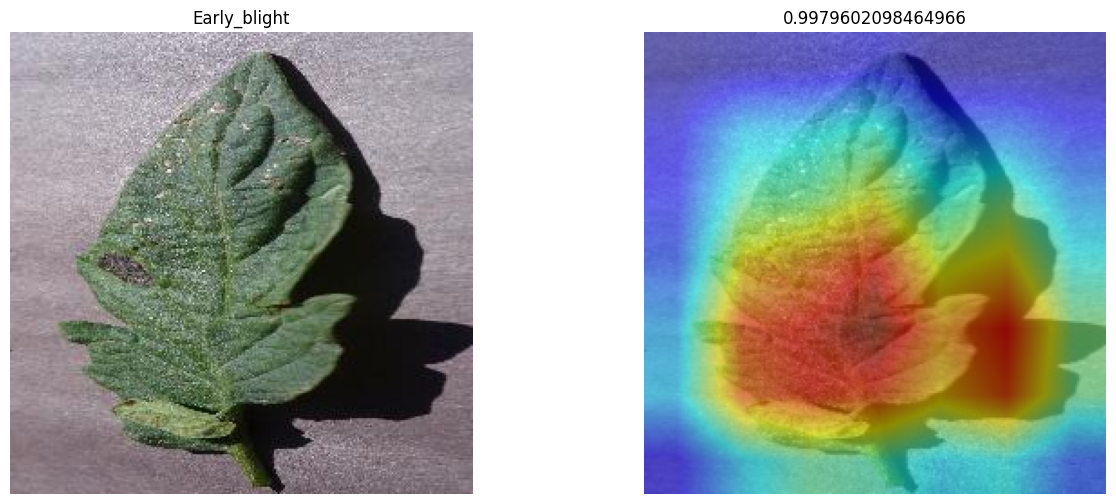

In [343]:
import matplotlib.pyplot as plt

random_img = random.choice(imgs)
# random_img = './data_test/la_tren_cay.jpg'
print(random_img)
img = Image.open(random_img)
results = await model.predict(img)

plt.figure(figsize=[15, 6])
plt.subplot(1, 2, 1)
plt.imshow(results['image'])
plt.title(results['class_name'])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(results['predicted_image'])
plt.title(results['class_prob'])
plt.axis("off")

Text(0.5, 1.0, '0.9998289346694946')

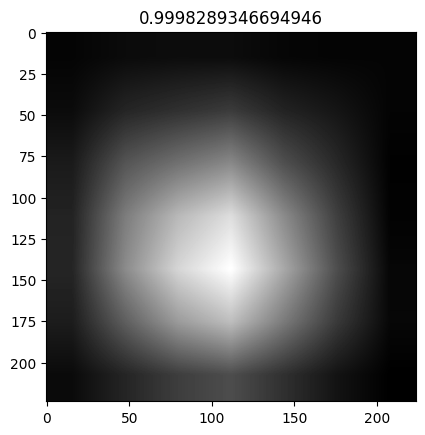

In [333]:
heatmap = np.copy(results['heatmap'])
# heatmap[heatmap < 0.8] = 0

plt.imshow(heatmap, cmap= 'gray')
plt.title(results['class_prob'])

In [155]:
flat_index = np.argmax(heatmap)

In [156]:
np.max(heatmap)

0.9999999

In [157]:
matrix_index = np.unravel_index(flat_index, heatmap.shape)
matrix_index

(175, 176)

In [158]:
heatmap[matrix_index[0], matrix_index[1]] = 0

In [159]:
heatmap[heatmap > 0.9]

array([0.90131015, 0.90122586, 0.90114164, 0.90105736, 0.9009731 ,
       0.9008888 , 0.9008046 , 0.9007203 , 0.9006361 , 0.90055186,
       0.9004676 , 0.90038335, 0.9002991 , 0.9002148 , 0.9001305 ,
       0.9000463 , 0.9014612 , 0.90743876, 0.91028196, 0.90999067,
       0.90969944, 0.90940815, 0.9091169 , 0.90882564, 0.9085344 ,
       0.9082431 , 0.9079519 , 0.90766066, 0.9073694 , 0.9070781 ,
       0.90678686, 0.90649563, 0.90620434, 0.9059131 , 0.9056218 ,
       0.9053306 , 0.9050393 , 0.9047481 , 0.90445673, 0.90416557,
       0.9038743 , 0.90358305, 0.90329176, 0.90300053, 0.9027093 ,
       0.902418  , 0.9021268 , 0.90183544, 0.9015442 , 0.901253  ,
       0.90483826, 0.91070414, 0.91656995, 0.91925377, 0.9187555 ,
       0.91825724, 0.91775894, 0.9172607 , 0.9167624 , 0.91626424,
       0.9157659 , 0.91526765, 0.9147695 , 0.9142712 , 0.91377294,
       0.91327465, 0.9127764 , 0.9122781 , 0.9117799 , 0.9112816 ,
       0.91078335, 0.9102851 , 0.9097869 , 0.9092886 , 0.90879